In [1]:
# Importing the libraries and data files

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score

from tqdm import tqdm
import pickle


import keras
from keras import layers
from keras.layers import TextVectorization
import tensorflow.keras.backend as K
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

from tensorflow.python.keras import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
%config InlineBackend.figure_format = 'svg'

In [3]:
data_partition_seed=3

In [4]:
eeg_non_seizure_data = np.load('./eeg_data_non_pre_seizure.npy')
eeg_pre_seizure_data = np.load('./eeg_data_pre_seizure.npy')
eeg_seizure_data = np.load('./eeg_data_seizure.npy')

#eeg_pre_seizure_data_zero_padding = np.load('./eeg_data_pre_seizure_chl60_pad_0.npy')
signal_labels = ['EEG Fp1-REF', 'EEG Fp2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG Fz-REF', 'EEG Cz-REF', 'EEG Pz-REF', 'ECG EKG-REF', 'Resp Effort-REF']

# Data curation

In [5]:
X_eeg_pre_seizure_data=eeg_pre_seizure_data[:,:19]

In [6]:
X_eeg_pre_seizure_data.shape

(2414, 19, 5120)

In [7]:
X_eeg_seizure_data=eeg_seizure_data[:,:19]

In [8]:
X_eeg_seizure_data.shape

(838, 19, 5120)

In [9]:
X_eeg_non_seizure_data=eeg_non_seizure_data[:,:19]

In [10]:
X_eeg_non_seizure_data.shape

(4467, 19, 5120)

In [11]:
def get_second_wise_stats_patient_channel(X,chunk):
    chunk_embedding=[]
    for channel in range(19):
        mean=np.mean(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        std=np.mean(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        min_=np.min(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        max_=np.max(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        median=np.median(np.array(np.split(X[chunk][channel],np.arange(int(X.shape[2]/256))*256)[1:]), axis=1)
        info=np.array([mean,std,min_,max_,median])
        chunk_embedding.append(info)
    chunk_embedding=np.array(chunk_embedding)
    return np.concatenate(chunk_embedding)

In [12]:
X_reduced_len_eeg_pre_seizure_data=[]
for i in tqdm(range(len(X_eeg_pre_seizure_data))):
    X_reduced_len_eeg_pre_seizure_data.append(get_second_wise_stats_patient_channel(X_eeg_pre_seizure_data,i))
X_reduced_len_eeg_pre_seizure_data=np.array(X_reduced_len_eeg_pre_seizure_data)

100%|██████████| 2414/2414 [00:07<00:00, 319.86it/s]


In [13]:
X_reduced_len_eeg_seizure_data=[]
for i in tqdm(range(len(X_eeg_seizure_data))):
    X_reduced_len_eeg_seizure_data.append(get_second_wise_stats_patient_channel(X_eeg_seizure_data,i))
X_reduced_len_eeg_seizure_data=np.array(X_reduced_len_eeg_seizure_data)

100%|██████████| 838/838 [00:02<00:00, 323.20it/s]


In [14]:
X_reduced_len_eeg_non_seizure_data=[]
for i in tqdm(range(len(X_eeg_non_seizure_data))):
    X_reduced_len_eeg_non_seizure_data.append(get_second_wise_stats_patient_channel(X_eeg_non_seizure_data,i))
X_reduced_len_eeg_non_seizure_data=np.array(X_reduced_len_eeg_non_seizure_data)

100%|██████████| 4467/4467 [00:14<00:00, 309.73it/s]


In [15]:
X_reduced_len_eeg_pre_seizure_data.shape

(2414, 95, 20)

In [16]:
X_reduced_len_eeg_seizure_data.shape

(838, 95, 20)

In [17]:
X_reduced_len_eeg_non_seizure_data.shape

(4467, 95, 20)

In [18]:
def scale_eeg(X):
    return np.array([np.array([(X[index][channel]-np.min(X[index][channel]))/(np.max(X[index][channel])-np.min(X[index][channel])+0.000001) for channel in range(X.shape[1])]) for index in range(len(X))])

In [19]:
X_reduced_len_eeg_pre_seizure_data=scale_eeg(X_reduced_len_eeg_pre_seizure_data)

In [20]:
X_reduced_len_eeg_seizure_data=scale_eeg(X_reduced_len_eeg_seizure_data)

In [21]:
X_reduced_len_eeg_non_seizure_data=scale_eeg(X_reduced_len_eeg_non_seizure_data)

In [22]:
X_reduced_len_eeg_pre_seizure_data=np.moveaxis(X_reduced_len_eeg_pre_seizure_data,-1,-2)

In [23]:
X_reduced_len_eeg_seizure_data=np.moveaxis(X_reduced_len_eeg_seizure_data,-1,-2)

In [24]:
X_reduced_len_eeg_non_seizure_data=np.moveaxis(X_reduced_len_eeg_non_seizure_data,-1,-2)

In [25]:
np.random.seed(data_partition_seed)

p = np.random.permutation(len(X_reduced_len_eeg_pre_seizure_data))
X_reduced_len_eeg_pre_and_seizure_data=X_reduced_len_eeg_pre_seizure_data[p]

q = np.random.permutation(len(X_reduced_len_eeg_seizure_data))
X_reduced_len_eeg_pre_and_seizure_data=X_reduced_len_eeg_seizure_data[q]

r = np.random.permutation(len(X_reduced_len_eeg_non_seizure_data))
X_reduced_len_eeg_non_seizure_data=X_reduced_len_eeg_non_seizure_data[r]

In [26]:
X_reduced_len_eeg_pre_seizure_data_just_for_preseizure_val=X_reduced_len_eeg_pre_seizure_data[-100:]

In [27]:
X_reduced_len_eeg_pre_seizure_data_just_for_preseizure_val.shape

(100, 20, 95)

In [28]:
X_reduced_len_eeg_pre_seizure_data=X_reduced_len_eeg_pre_seizure_data[:-100]

In [29]:
print(X_reduced_len_eeg_pre_seizure_data.shape)
print(X_reduced_len_eeg_seizure_data.shape)
print(X_reduced_len_eeg_non_seizure_data.shape)

(2314, 20, 95)
(838, 20, 95)
(4467, 20, 95)


In [30]:
X_reduced_len_eeg_pre_and_seizure_data=np.concatenate([X_reduced_len_eeg_seizure_data,X_reduced_len_eeg_pre_seizure_data])

In [31]:
pre_and_seiz_trn=int(X_reduced_len_eeg_pre_and_seizure_data.shape[0]*.9)
non_seiz_trn=int(X_reduced_len_eeg_non_seizure_data.shape[0]*.9)

In [32]:
y_train=[]
for i in range(X_reduced_len_eeg_pre_and_seizure_data[:pre_and_seiz_trn].shape[0]):
    y_train.append(np.array([0,1]))
for i in range(X_reduced_len_eeg_non_seizure_data[:non_seiz_trn].shape[0]):
    y_train.append(np.array([1,0]))

y_train=np.array(y_train)

In [33]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [34]:
X_train=np.concatenate([X_reduced_len_eeg_pre_and_seizure_data[:pre_and_seiz_trn],X_reduced_len_eeg_non_seizure_data[:non_seiz_trn]])

In [35]:
X_train, y_train=unison_shuffled_copies(X_train, y_train)

In [36]:
print(X_train.shape, y_train.shape)

(6856, 20, 95) (6856, 2)


In [37]:
y_test=[]

for i in range(X_reduced_len_eeg_pre_and_seizure_data[pre_and_seiz_trn:].shape[0]):
    y_test.append(np.array([0,1]))
for i in range(X_reduced_len_eeg_non_seizure_data[non_seiz_trn:].shape[0]):
    y_test.append(np.array([1,0]))

y_test=np.array(y_test)

In [38]:
X_test=np.concatenate([X_reduced_len_eeg_pre_and_seizure_data[pre_and_seiz_trn:],X_reduced_len_eeg_non_seizure_data[non_seiz_trn:]])

In [39]:
X_test, y_test=unison_shuffled_copies(X_test, y_test)

In [40]:
print(X_test.shape, y_test.shape)

(763, 20, 95) (763, 2)


# Model training

In [41]:
#@keras.saving.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, embed_dim, **kwargs):
        super().__init__(**kwargs)

        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        
        self.sequence_length = sequence_length
        self.embed_dim = embed_dim

    def call(self, inputs):
        dummy=tf.zeros_like(inputs, dtype=None, name=None)
        length = tf.shape(inputs)[-2]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return dummy+embedded_positions


    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [42]:
embed_dim = X_train.shape[2]
latent_dim = 1024
num_heads = 6
signal_len = X_train.shape[1]

def get_model():
    signal = keras.Input(shape=(signal_len, embed_dim), dtype="float64")

    pos_emb_1= PositionalEmbedding(signal_len, embed_dim, name='pos_emb_1_ch_1')(signal)

    signal=tf.keras.layers.Add()([signal, pos_emb_1])

    signal_lstm = layers.LSTM(units=256, return_sequences=True, activation="tanh")(signal)

    pos_emb_2= PositionalEmbedding(signal_len, 256, name='pos_emb_2_ch_1')(signal_lstm)
    
    signal_pos=tf.keras.layers.Add()([signal_lstm, pos_emb_2])
    
    x_att= keras.layers.MultiHeadAttention(num_heads, embed_dim)(query=signal_pos, value=signal_pos, key=signal_pos)

    x_res1=tf.keras.layers.Add()([x_att, signal_pos])
    x_ln1=layers.LayerNormalization()(x_res1)
    
    x_2 = layers.Dense(latent_dim, activation="relu")(x_ln1)
    x_2=layers.Dense(embed_dim)(x_2)

    x_res2=tf.keras.layers.Add()([x_att, x_ln1])
    x_ln2=layers.LayerNormalization()(x_res2)
    
    x_3 = keras.layers.Flatten()(x_ln2)
    output = keras.layers.Dense(2, activation='softmax')(x_3)
    model = keras.Model(inputs=signal, outputs=output)
    return model

transformer_model = get_model()

In [43]:
tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

model=get_model()

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 20, 95)]     0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 20, 256)      360448      ['input_4[0][0]']                
                                                                                                  
 pos_emb_2_ch_1 (PositionalEmbe  (None, 20, 256)     5120        ['lstm_1[1][0]']                 
 dding)                                                                                           
                                                                                                  
 add_5 (Add)                    (None, 20, 256)      0           ['lstm_1[1][0]',           

In [45]:
def weighted_binary_crossentropy(target, output, weights):
    target = tf.convert_to_tensor(target)
    output = tf.convert_to_tensor(output)
    weights = tf.convert_to_tensor(weights, dtype=target.dtype)

    epsilon_ = tf.constant(tf.keras.backend.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, epsilon_, 1.0 - epsilon_)

    # Compute cross-entropy from probabilities.
    bce = weights[1] * target * tf.math.log(output + epsilon_)
    bce += weights[0] * (1 - target) * tf.math.log(1 - output + epsilon_)
    return -bce

class WeightedBinaryCrossentropy:
    def __init__(
        self,
        label_smoothing=0.0,
        weights = [1.0, 1.0],
        axis=-1,
        name="weighted_binary_crossentropy",
        fn = None,
    ):
        """Initializes `WeightedBinaryCrossentropy` instance.
        Args:
          from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](https://en.wikipedia.org/wiki/Logit) values. By default, we
            assume that `y_pred` contains probabilities (i.e., values in [0,
            1]).
          label_smoothing: Float in [0, 1]. When 0, no smoothing occurs. When >
            0, we compute the loss between the predicted labels and a smoothed
            version of the true labels, where the smoothing squeezes the labels
            towards 0.5.  Larger values of `label_smoothing` correspond to
            heavier smoothing.
          axis: The axis along which to compute crossentropy (the features
            axis).  Defaults to -1.
          name: Name for the op. Defaults to 'weighted_binary_crossentropy'.
        """
        super().__init__()
        self.weights = weights # tf.convert_to_tensor(weights)
        self.label_smoothing = label_smoothing
        self.name = name
        self.fn = weighted_binary_crossentropy if fn is None else fn

    def __call__(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        self.label_smoothing = tf.convert_to_tensor(self.label_smoothing, dtype=y_pred.dtype)

        def _smooth_labels():
            return y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing

        y_true = tf.__internal__.smart_cond.smart_cond(self.label_smoothing, _smooth_labels, lambda: y_true)

        return tf.reduce_mean(self.fn(y_true, y_pred, self.weights),axis=-1)

    def get_config(self):
        config = {"name": self.name, "weights": self.weights, "fn": self.fn}

        # base_config = super().get_config()
        return dict(list(config.items()))

    @classmethod
    def from_config(cls, config):
        """Instantiates a `Loss` from its config (output of `get_config()`).
        Args:
            config: Output of `get_config()`.
        """
        if saving_lib.saving_v3_enabled():
            fn_name = config.pop("fn", None)
            if fn_name:
                config["fn"] = get(fn_name)
        return cls(**config)

In [46]:
epochs = 65
#wbce = WeightedBinaryCrossentropy(weights = [1.0, 3.0])
model.compile(keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy')
history=model.fit(X_train, y_train, epochs= epochs, shuffle=True, validation_split=0.05)

Epoch 1/65
204/204 [==============================] - 4s 8ms/step - loss: 0.6837 - val_loss: 0.6628
Epoch 2/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6595 - val_loss: 0.6693
Epoch 3/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6525 - val_loss: 0.6410
Epoch 4/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6414 - val_loss: 0.6427
Epoch 5/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6348 - val_loss: 0.6304
Epoch 6/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6294 - val_loss: 0.6374
Epoch 7/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6242 - val_loss: 0.6198
Epoch 8/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6223 - val_loss: 0.6199
Epoch 9/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6151 - val_loss: 0.6139
Epoch 10/65
204/204 [==============================] - 1s 7ms/step - loss: 0.6128 - val_loss: 0.6108

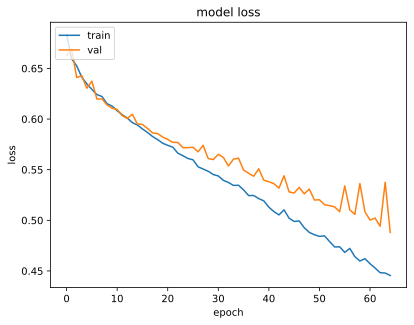

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model validation: Level 1

## Validation for the entire test data

In [48]:
y_pred=model.predict(X_test)

24/24 [==============================] - 0s 3ms/step


In [49]:
print('Accuracy',accuracy_score(y_test[:,1], np.argmax(y_pred,axis=1)))
print('Pre and Seizure detection rate', confusion_matrix(y_test[:,1], np.argmax(y_pred,axis=1))[1][1]/np.sum(confusion_matrix(y_test[:,1], np.argmax(y_pred,axis=1))[1]))
print('False alarm rate', confusion_matrix(y_test[:,1], np.argmax(y_pred,axis=1))[0][1]/np.sum(confusion_matrix(y_test[:,1], np.argmax(y_pred,axis=1))[:,1]))

Accuracy 0.8623853211009175
Pre and Seizure detection rate 0.8987341772151899
False alarm rate 0.20448179271708683


In [50]:
confusion_matrix(y_test[:,1], np.argmax(y_pred,axis=1))

array([[374,  73],
       [ 32, 284]], dtype=int64)

## Validation for the some pre-seizure data previously kept separate before train test split

In [51]:
y_pred_just_for_preseizure_val=model.predict(X_reduced_len_eeg_pre_seizure_data_just_for_preseizure_val)

4/4 [==============================] - 0s 7ms/step


In [52]:
print("percentage of only pre seizure chunks deteced: ",np.sum(np.argmax(y_pred_just_for_preseizure_val,axis=1))*100/len(X_reduced_len_eeg_pre_seizure_data_just_for_preseizure_val))

percentage of only pre seizure chunks deteced:  94.0


# Model validation: Level 2

In [53]:
file_path = './all_val_patient_chunks.pkl'

with open(file_path , 'rb') as f:
    validation_eeg_data = pickle.load(f)

In [54]:
file_path = './second_wise_label_doctor_A_val_patients.pkl'

with open(file_path , 'rb') as f:
    validation_second_wise_A = pickle.load(f)

In [55]:
file_path = './second_wise_label_doctor_B_val_patients.pkl'

with open(file_path , 'rb') as f:
    validation_second_wise_B = pickle.load(f)

In [56]:
file_path = './second_wise_label_doctor_C_val_patients.pkl'

with open(file_path , 'rb') as f:
    validation_second_wise_C = pickle.load(f)

In [57]:
file_path = './all_val_patient_indexes.pkl'

with open(file_path , 'rb') as f:
    val_patient_original_indexes = pickle.load(f)

In [58]:
def independent_val_results_patient(val_patient_index, doc='A'):
    predictions_eeg_pre_seizure_data_for_val=[]
    
    predictions_eeg_pre_seizure_data_for_val=model.predict(validation_eeg_data[val_patient_index])
    predictions_eeg_pre_seizure_data_for_val=np.argmax(predictions_eeg_pre_seizure_data_for_val,axis=1)
    
    validation_gap_wise_A_patient=[]
    starting_point=0
    for i in range(validation_second_wise_A[val_patient_index].shape[0]):
        if i%3==0:
            validation_gap_wise_A_patient.append(int(validation_second_wise_A[val_patient_index][i]))
    
    validation_gap_wise_B_patient=[]
    starting_point=0
    for i in range(validation_second_wise_B[val_patient_index].shape[0]):
        if i%3==0:
            validation_gap_wise_B_patient.append(int(validation_second_wise_B[val_patient_index][i]))
    
    validation_gap_wise_C_patient=[]
    starting_point=0
    for i in range(validation_second_wise_C[val_patient_index].shape[0]):
        if i%3==0:
            validation_gap_wise_C_patient.append(int(validation_second_wise_C[val_patient_index][i]))

    if doc=='A':
        return predictions_eeg_pre_seizure_data_for_val, validation_gap_wise_A_patient
    elif doc=='B':
        return predictions_eeg_pre_seizure_data_for_val, validation_gap_wise_B_patient
    elif doc=='C':
        return predictions_eeg_pre_seizure_data_for_val, validation_gap_wise_C_patient
    else: print('Input type parameter as either "A", "B" or "C"')
    
    

In [59]:
validation_gap_wise_patient=[]
predictions_eeg_pre_seizure_data_for_val_raw_signals=[]
for index in range(len(validation_eeg_data)):
    predictions_eeg_pre_seizure_data_for_val, validation_gap_wise_A_patient=independent_val_results_patient(index,'A')
    predictions_eeg_pre_seizure_data_for_val, validation_gap_wise_B_patient=independent_val_results_patient(index,'B')
    predictions_eeg_pre_seizure_data_for_val, validation_gap_wise_C_patient=independent_val_results_patient(index,'C')
    validation_gap_wise_patient.append([validation_gap_wise_A_patient,validation_gap_wise_B_patient,validation_gap_wise_C_patient])
    predictions_eeg_pre_seizure_data_for_val_raw_signals.append(predictions_eeg_pre_seizure_data_for_val)

40/40 [==============================] - 0s 2ms/step


In [60]:
def clean_up_prediction_signal(predictions_eeg_pre_seizure_data_for_val, threshold=15):
    i=0
    cleaned_up_predictions_eeg_pre_seizure_data_for_val=np.zeros_like(predictions_eeg_pre_seizure_data_for_val)
    positive_indices=[]
    while i<=(len(predictions_eeg_pre_seizure_data_for_val)-threshold):
        s=0
        for j in range(i,i+threshold):
            s=s+predictions_eeg_pre_seizure_data_for_val[j]
        s=s/threshold
        
        if s==1:
            i=i+threshold
            for k in range(i,i+threshold):
                positive_indices.append(k)
        else:
            i=i+1

    for i in range(len(cleaned_up_predictions_eeg_pre_seizure_data_for_val)):
        if i in positive_indices:
            cleaned_up_predictions_eeg_pre_seizure_data_for_val[i]=1
    return cleaned_up_predictions_eeg_pre_seizure_data_for_val

In [61]:
cleaned_signals=[]
for i in range(len(predictions_eeg_pre_seizure_data_for_val_raw_signals)):
    cleaned_signals.append(clean_up_prediction_signal(predictions_eeg_pre_seizure_data_for_val_raw_signals[i]))

In [62]:
cleaned_annotations=validation_gap_wise_patient

In [63]:
def vizualize_prediction_single_patient(cleaned_up_predictions_eeg_pre_seizure_data_for_val, common_seizure_points):
    plt.figure(figsize=(5,.5)) 
    plt.plot(np.arange(len(common_seizure_points)), np.array(common_seizure_points),color='red',linewidth=0.5)
    plt.plot(np.arange(len(cleaned_up_predictions_eeg_pre_seizure_data_for_val)), np.array(cleaned_up_predictions_eeg_pre_seizure_data_for_val),color='green',linewidth=0.25)
    plt.yticks([0,1])
    plt.tick_params(axis='both',  labelsize=5)
    plt.show()

In [64]:
def getsubplot_val(patient_index):
    plt.rcParams['axes.linewidth'] = 0.15
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(7,0.5))
    fig.suptitle('Val patient number: '+str(val_patient_original_indexes[patient_index]), fontsize=6,  y=1.15)
    plt.figure(figsize=(3,.1)) 
    
    ax1.plot(np.arange(len(cleaned_annotations[patient_index][0])), np.array(cleaned_annotations[patient_index][0]),color='red',linewidth=0.5)
    ax1.plot(np.arange(len(cleaned_signals[patient_index])), np.array(cleaned_signals[patient_index]),color='green',linewidth=0.25)
    ax1.set_yticks([0,1])
    ax1.tick_params(axis='both',  labelsize=5)
    
     
    ax2.plot(np.arange(len(cleaned_annotations[patient_index][1])), np.array(cleaned_annotations[patient_index][1]),color='red',linewidth=0.5)
    ax2.plot(np.arange(len(cleaned_signals[patient_index])), np.array(cleaned_signals[patient_index]),color='green',linewidth=0.25)
    ax2.set_yticks([0,1])
    ax2.tick_params(axis='both',  labelsize=5)
    
    ax3.plot(np.arange(len(cleaned_annotations[patient_index][2])), np.array(cleaned_annotations[patient_index][2]),color='red',linewidth=0.5)
    ax3.plot(np.arange(len(cleaned_signals[patient_index])), np.array(cleaned_signals[patient_index]),color='green',linewidth=0.25)
    ax3.set_yticks([0,1])
    ax3.tick_params(axis='both',  labelsize=5)
    
    
    fig.savefig(str(val_patient_original_indexes[patient_index])+'.png',dpi=300, bbox_inches="tight")

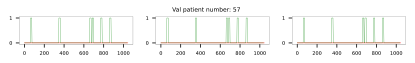

<Figure size 300x10 with 0 Axes>

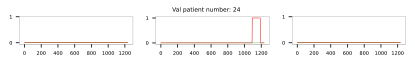

<Figure size 300x10 with 0 Axes>

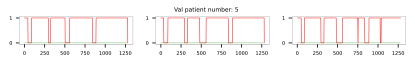

<Figure size 300x10 with 0 Axes>

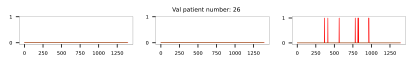

<Figure size 300x10 with 0 Axes>

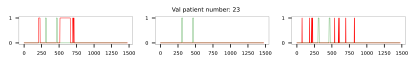

<Figure size 300x10 with 0 Axes>

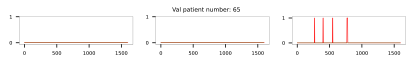

<Figure size 300x10 with 0 Axes>

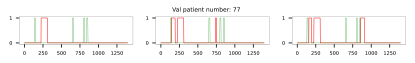

<Figure size 300x10 with 0 Axes>

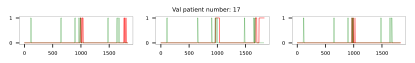

<Figure size 300x10 with 0 Axes>

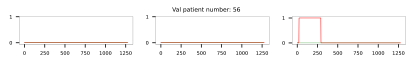

<Figure size 300x10 with 0 Axes>

In [65]:
for patient_index in range(len(val_patient_original_indexes)):
    getsubplot_val(patient_index)